In [122]:
import keras
import pandas as pd
import os
import sys
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model
from sklearn.model_selection import train_test_split

In [123]:
def word_split(mystring):
    str_split = []
    nltk_stopwords= nltk.corpus.stopwords.words('english')
    for tmp in mystring:
        tmp = tmp.lower()
        punct_token = wordpunct_tokenize(tmp)
        '''
        tmp = re.sub('[^a-zA-Z0-9\s\?\!]+', '', tmp)
        tmp = tmp.replace('!', ' !')
        tmp = tmp.replace('?', ' ?')
        tmp = tmp.split(' ')
        '''
        punct_token = [word for word in punct_token if word not in nltk_stopwords]
        #remove string.punctuation
        punct_token = [word for word in punct_token if word not in string.punctuation]
        '''
        while True:
            if '' not in tmp:
                break
            tmp.remove('')
        while True:
            if 'the' not in tmp:
                break
            tmp.remove('the')
        while True:
            if 'and' not in tmp:
                break
            tmp.remove('and')
        while True:
            if 'of' not in tmp:
                break
            tmp.remove('of')
        while True:
            if 'is' not in tmp:
                break
            tmp.remove('is')
        while True:
            if 'are' not in tmp:
                break
            tmp.remove('are')
        '''
        str_split.append(punct_token)
    return str_split

In [124]:
import nltk
nltk.download('stopwords')
import string
from nltk import wordpunct_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [154]:
GLOVE_DIR = './'
MAX_SEQUENCE_LENGTH = 30
MAX_NB_WORDS = 1000
EMBEDDING_DIM = 100
NUM_LSTM_UNITS = 100
VALIDATION_SPLIT = 0.2

In [155]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [177]:
all_data = pd.read_csv("train.csv")
data = all_data['Headline']
label = all_data['Label']
my_split = word_split(data)

In [178]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(my_split)
sequences = tokenizer.texts_to_sequences(my_split)
word_index = tokenizer.word_index
x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [179]:
num_words = min(MAX_NB_WORDS, len(word_index))+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [180]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [181]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
shared_lstm = LSTM(NUM_LSTM_UNITS)
xx = shared_lstm(embedded_sequences)
predictions = Dense(units=1, activation='linear')(xx)
model = Model(inputs=sequence_input, outputs=predictions)

In [182]:
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(0.001))
model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 30, 100)           100100    
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 180,601
Trainable params: 80,501
Non-trainable params: 100,100
_________________________________________________________________


In [183]:
x_train, x_test, y_train, y_test = train_test_split(x, label, test_size=0.2)

In [184]:
history = model.fit(x_train, y_train ,batch_size=32 ,epochs=6,validation_data=(x_test, y_test))

Epoch 1/6
51/51 [==============================] - 1s 12ms/step - loss: 1.7594 - val_loss: 0.5307
Epoch 2/6
51/51 [==============================] - 0s 8ms/step - loss: 0.4935 - val_loss: 0.4739
Epoch 3/6
51/51 [==============================] - 0s 8ms/step - loss: 0.4734 - val_loss: 0.4590
Epoch 4/6
51/51 [==============================] - 0s 8ms/step - loss: 0.4588 - val_loss: 0.4683
Epoch 5/6
51/51 [==============================] - 0s 8ms/step - loss: 0.4487 - val_loss: 0.4503
Epoch 6/6
51/51 [==============================] - 0s 8ms/step - loss: 0.4395 - val_loss: 0.4718


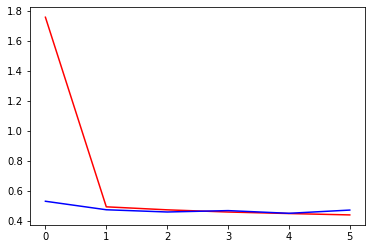

In [185]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,'r', val_loss, 'b')

In [186]:
test_data = pd.read_csv("test.csv")
data = test_data['Headline']
label = test_data['Label']
test_split = word_split(data)
sequences = tokenizer.texts_to_sequences(test_split)
x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y_pre = model.predict(x)
b = np.arange(1, y_pre.shape[0]+1).reshape(y_pre.shape[0], 1)
y_pre = np.append(b, y_pre, axis=1)

In [187]:
import csv
with open('output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID','Label'])
    writer.writerows(y_pre)

In [188]:
a = pd.read_csv('output5.csv')
my = pd.read_csv('output.csv')
a1 = a.pop('Label').to_numpy()
my1 = my.pop('Label').to_numpy()

In [189]:
MSE = np.sqrt(np.power(a1-my1, 2).mean())
print(MSE)

0.26928948324382074
